<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/transformers_lp_course/sentiment_analysis_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 04:54:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 14.9 MB/s 
     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 212 kB 87.0 MB/s 
     |████████████████████████████████| 86 kB 2.4 MB/s 
     |████████████████████████████████| 140 kB 94.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.4 MB/s 
     |████████████████████████████████| 596 kB 91.0 MB/s 
     |████████████████████████████████| 127 kB 97.9 MB/s 
     |████████████████████████████████| 271 kB 93.0 MB/s 
     |████████████████████████████████| 144 kB 82.2 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 104.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing i

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 62.3 MB/s 


In [5]:
!pip3 install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import transformers 
import  matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np 
import pandas as pd 
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import load_metric


## Datasets

In [7]:
raw_datasets = load_dataset("glue","sst2")


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [9]:
print(raw_datasets['train'])
print(dir(raw_datasets['train']))

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})
['_TF_DATASET_REFS', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_local_temp_path', '_check_index_is_initialized', '_data', '_fingerprint', '_format_columns', '_format_kwargs', '_format_type', '_get_cache_file_path', '_get_output_signature', '_getitem', '_indexes', '_indices', '_info', '_iter', '_map_single', '_new_dataset_with_indices', '_output_all_columns', '_push_parquet_shards_to_hub', '_split', 'add_column', 'add_elasticsearch_index', 'add_faiss_index', 'add_faiss_index_from_external_arrays', 'add_item', 'align_labels_with_mapping

In [10]:
type(raw_datasets['train'])

datasets.arrow_dataset.Dataset

In [11]:
raw_datasets['train'].data

MemoryMappedTable
sentence: string
label: int64
idx: int32
----
sentence: [["hide new secretions from the parental units ","contains no wit , only labored gags ","that loves its characters and communicates something rather beautiful about human nature ","remains utterly satisfied to remain the same throughout ","on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ","that 's far too tragic to merit such superficial treatment ","demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ","of saucy ","a depressed fifteen-year-old 's suicidal poetry ","are more deeply thought through than in most ` right-thinking ' films ",...,"sealed with a kiss ","very ugly ","why this project was undertaken ","the mill sci-fi film with a flimsy ending and ","halfhearted ","dilutes the pleasure of watching them ","the emotion is impressively true for being so hot-blooded , and ","can get your m

In [12]:
raw_datasets['train'][0]

{'idx': 0,
 'label': 0,
 'sentence': 'hide new secretions from the parental units '}

In [13]:
raw_datasets['train'][50000:50003]

{'idx': [50000, 50001, 50002],
 'label': [1, 1, 1],
 'sentence': ['glow ',
  'a classical dramatic animated feature ',
  'best espionage picture ']}

In [14]:
raw_datasets['train'].features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], id=None),
 'sentence': Value(dtype='string', id=None)}

In [15]:
len(raw_datasets['train'])

67349

In [16]:
raw_datasets['train'].column_names

['sentence', 'label', 'idx']

In [17]:
raw_datasets['train']['sentence'][:5]

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ']

##From Datasets to DataFrame


In [18]:
raw_datasets.set_format(type='pandas')
tweet_data = raw_datasets['train'][:]

In [19]:

int2str_label = raw_datasets['train'].features['label'].names
int2str_mapping = {k:v for k,v in enumerate(int2str_label)}
int2str_mapping

{0: 'negative', 1: 'positive'}

In [20]:
%%timeit
tweet_data['label_name']= tweet_data['label'].map(int2str_mapping)

1000 loops, best of 5: 1.64 ms per loop


In [21]:
tweet_data.head()

,sentence,label,idx,label_name
0,hide new secretions from the parental units,0,0,negative
1,"contains no wit , only labored gags",0,1,negative
2,that loves its characters and communicates som...,1,2,positive
3,remains utterly satisfied to remain the same t...,0,3,negative
4,on the worst revenge-of-the-nerds clichés the ...,0,4,negative


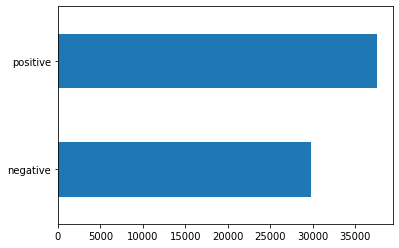

In [22]:
tweet_data['label_name'].value_counts(ascending=True).plot.barh()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


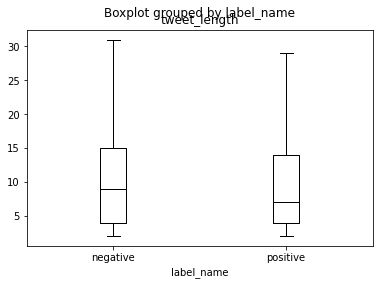

In [23]:
tweet_data['tweet_length']= tweet_data['sentence'].apply(lambda x: len(x.split(' ')))
tweet_data.boxplot("tweet_length", by="label_name", color="black",grid=False, showfliers=False)

In [24]:
tweet_data.groupby(['label_name'])['tweet_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
negative,29780.0,10.882874,8.157512,2.0,4.0,9.0,15.0,53.0
positive,37569.0,10.034363,7.987037,2.0,4.0,7.0,14.0,53.0


In [25]:
raw_datasets.reset_format()

## From Text to Tokenization


In [26]:
from transformers import AutoTokenizer

In [27]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

### Text Tokens to Integer Ids

In [28]:
tokenized_sentences = tokenizer(raw_datasets['train'][0:3]['sentence'])
pprint(tokenized_sentences)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
                2015,
                2242,
                2738,
                3376,
                2055,
                2529,
                3267,
                102]]}


### Integer Ids to Tokens

In [29]:
back2tokens = tokenizer.convert_ids_to_tokens(tokenized_sentences['input_ids'][0])
back2tokens

['[CLS]',
 'hide',
 'new',
 'secret',
 '##ions',
 'from',
 'the',
 'parental',
 'units',
 '[SEP]']

In [30]:
print(tokenizer.convert_tokens_to_string(back2tokens))

[CLS] hide new secretions from the parental units [SEP]


### Tokenization the entire dataset

In [31]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True,padding=True)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [32]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [33]:
pprint(tokenize_fn(raw_datasets['train'][:3]))

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101,
                5342,
                2047,
                3595,
                8496,
                2013,
                1996,
                18643,
                3197,
                102,
                0,
                0,
                0,
                0,
                0],
               [101,
                3397,
                2053,
                15966,
                1010,
                2069,
                4450,
                2098,
                18201,
                2015,
                102,
                0,
                0,
                0,
                0],
               [101,
                2008,
                7459,
                2049,
                3494,
                1998,
                10639,
          

###Fine Tuning
- Getting the pre_trained model
- All the parameters will be trained with a very slow learning rate. 

### Training Arguments

In [34]:
from transformers import TrainingArguments

In [35]:
from transformers import training_args
batch_size= 64
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "airline_tweet_analysis_model"
training_args = TrainingArguments(
    'airline_tweet_lp',
    evaluation_strategy='epoch',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

In [36]:
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt =  'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels=2



In [37]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [38]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [39]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [40]:
#from torchinfo import summary
#summary(model,input_size=(batch_size,512), dtypes=['torch.IntTensor'],device='cpu')
#summary(model)

In [41]:
params_before = []
for name, p in model.named_parameters():
  print(name,p.shape)
  params_before.append(p.detach().cpu().numpy())

distilbert.embeddings.word_embeddings.weight torch.Size([30522, 768])
distilbert.embeddings.position_embeddings.weight torch.Size([512, 768])
distilbert.embeddings.LayerNorm.weight torch.Size([768])
distilbert.embeddings.LayerNorm.bias torch.Size([768])
distilbert.transformer.layer.0.attention.q_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.q_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.k_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.k_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.v_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.v_lin.bias torch.Size([768])
distilbert.transformer.layer.0.attention.out_lin.weight torch.Size([768, 768])
distilbert.transformer.layer.0.attention.out_lin.bias torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.weight torch.Size([768])
distilbert.transformer.layer.0.sa_layer_norm.bias torch.Size([768])
distilbert.trans

In [47]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}



In [43]:
metric = load_metric("glue","sst2")

In [44]:
metric.compute(predictions=[1,0,1], references=[1,0,1])

{'accuracy': 1.0}

## Trainer

In [48]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['validation'],
                  tokenizer=tokenizer)

In [49]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.105000,0.314432,0.913991,"(0.9139571989433398,)"
2,0.090500,0.306503,0.908257,"(0.9082254828665943,)"


TrainOutput(global_step=2106, training_loss=0.09766584424990081, metrics={'train_runtime': 422.8365, 'train_samples_per_second': 318.558, 'train_steps_per_second': 4.981, 'total_flos': 2293899133717752.0, 'train_loss': 0.09766584424990081, 'epoch': 2.0})

In [50]:
pred_outputs = trainer.predict(tokenized_dataset['validation'])

In [51]:
pred_outputs.metrics

{'test_accuracy': 0.908256880733945,
 'test_f1': (0.9082254828665943,),
 'test_loss': 0.30650344491004944,
 'test_runtime': 0.8508,
 'test_samples_per_second': 1024.884,
 'test_steps_per_second': 16.455}

In [54]:
y_preds = np.argmax(pred_outputs.predictions,axis=1)

In [58]:
y_valid = np.array(tokenized_dataset['validation']["label"])

In [56]:
labels = tokenized_dataset["train"].features["label"].names

In [60]:
cm = confusion_matrix(y_valid, y_preds, labels=[0,1])

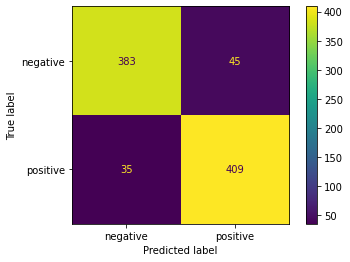

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

##Saving the model

In [62]:
trainer.save_model('my_saved_model')

In [63]:
!ls

airline_tweet_lp  my_saved_model  sample_data


In [64]:
from transformers import pipeline

In [66]:
newmodel = pipeline('text-classification',model='my_saved_model',device=0)

In [67]:
newmodel('this airline does not give any good meal')

[{'label': 'LABEL_0', 'score': 0.9979324340820312}]

In [68]:
newmodel('i think this airline would have been good if they had inflight entertainement')

[{'label': 'LABEL_0', 'score': 0.9684269428253174}]

In [69]:
newmodel('this flight was peace')

[{'label': 'LABEL_1', 'score': 0.9932637214660645}]